In [1]:
import math
import numpy as np
import torch
import torchvision
import transformers

device = torch.device("cuda")

#image_processor = transformers.AutoImageProcessor.from_pretrained("microsoft/resnet-50")
image_processor = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    #lambda x: x / 255,
])

In [2]:
import torchvision
model = torchvision.models.vgg19(pretrained=True).features
for param in model.parameters():
    param.requires_grad_(False)
model.to(device)
for field in dir(model):
    if not callable(getattr(model, field)):
        print(field, type(getattr(model, field)))

T_destination <class 'typing.TypeVar'>
__annotations__ <class 'dict'>
__dict__ <class 'dict'>
__doc__ <class 'str'>
__module__ <class 'str'>
__weakref__ <class 'NoneType'>
_backward_hooks <class 'collections.OrderedDict'>
_buffers <class 'collections.OrderedDict'>
_forward_hooks <class 'collections.OrderedDict'>
_forward_pre_hooks <class 'collections.OrderedDict'>
_is_full_backward_hook <class 'NoneType'>
_load_state_dict_post_hooks <class 'collections.OrderedDict'>
_load_state_dict_pre_hooks <class 'collections.OrderedDict'>
_modules <class 'collections.OrderedDict'>
_non_persistent_buffers_set <class 'set'>
_parameters <class 'collections.OrderedDict'>
_state_dict_hooks <class 'collections.OrderedDict'>
_version <class 'int'>
dump_patches <class 'bool'>
training <class 'bool'>


(255, 198)


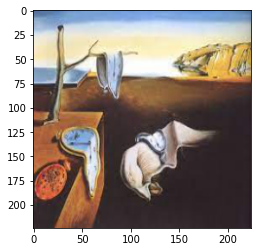

torch.Size([1, 3, 224, 224])
torch.Size([1, 64, 224, 224])
tensor(42313.2500, device='cuda:0')
tensor(239.1898, device='cuda:0')

torch.Size([1, 128, 112, 112])
tensor(397302.4688, device='cuda:0')
tensor(1085.9937, device='cuda:0')

torch.Size([1, 256, 56, 56])
tensor(1121387.5000, device='cuda:0')
tensor(22324.2227, device='cuda:0')

torch.Size([1, 512, 28, 28])
tensor(1859106., device='cuda:0')
tensor(171609.5000, device='cuda:0')

torch.Size([1, 512, 28, 28])
tensor(1193343., device='cuda:0')
tensor(79276.3516, device='cuda:0')

torch.Size([1, 512, 14, 14])
tensor(149262.1562, device='cuda:0')
tensor(15095.6152, device='cuda:0')



In [3]:
import matplotlib.pyplot as plt
import PIL

def content_loss(a, b):
    diff2 = (a - b)
    diff2 = diff2 * diff2
    return torch.sum(diff2) / 2

def gram(layer):
    shape = layer.shape
    features = layer.reshape((shape[0], shape[1], shape[2] * shape[3]))
    g = torch.matmul(features, features.transpose(1, 2))
    return g

def style_loss(a, b):
    a_gram, b_gram = gram(a), gram(b)
    diff2 = (a_gram - b_gram)
    diff2 = diff2 * diff2
    return torch.sum(diff2) / 2 / a.shape[1] / a.shape[2] / a.shape[3]

def get_features(image, model):
    layers = {
        '0': 'conv1_1',
        '5':  'conv2_1',
        '10': 'conv3_1',
        '19': 'conv4_1',
        '21': 'conv4_2',
        '28': 'conv5_1',
    }   
    features = []
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features.append(x)
    return features

dog = PIL.Image.open('dog6.jpeg')
#print(np.asarray(dog))
time = PIL.Image.open('time2.jpeg')
#dog.show()
print(dog.size)

dog_inputs = image_processor(dog).unsqueeze(0).to(device)
#print(dog_inputs)
#print(torch.min(dog_inputs))
time_inputs = image_processor(time).unsqueeze(0).to(device)
plt.imshow(time_inputs.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
plt.show()
print(dog_inputs.shape)
with torch.no_grad():
    dog_outputs = get_features(dog_inputs, model)
    time_outputs = get_features(time_inputs, model)
    #print(dog_outputs)

for dog_state, time_state in zip(dog_outputs, time_outputs):
    print(dog_state.shape)
    print(content_loss(dog_state, time_state))
    print(style_loss(dog_state, time_state))
    print("")    

In [9]:
def apply_style_transfer(content_path, style_path, iterations, checkpoints):
    content_target = PIL.Image.open(content_path)
    style_target = PIL.Image.open(style_path)

    img = torch.tensor(image_processor(content_target).unsqueeze(0), requires_grad=True, device=device)
    #img = torch.rand((1, 3, 224, 224), requires_grad=True, device=device)
    print(img.shape)

    with torch.no_grad():
        content_inputs = image_processor(content_target).unsqueeze(0).to(device)
        style_inputs = image_processor(style_target).unsqueeze(0).to(device)
        content_outputs = get_features(content_inputs, model)
        style_outputs = get_features(style_inputs, model)

    optimiser = torch.optim.Adam([img], lr = 1e-3, eps = 1e-12)
    for i in range(iterations + 1):
        optimiser.zero_grad()
        img_outputs = get_features(img, model)
        loss = (
            #content_loss(img_outputs[0], content_outputs[0])+
            #content_loss(img_outputs[1], content_outputs[1])
            #content_loss(img_outputs[2], content_outputs[2])+
            #content_loss(img_outputs[3], content_outputs[3])+
            content_loss(img_outputs[4], content_outputs[4])+
            content_loss(img_outputs[5], content_outputs[5])
        ) / 2 + (
            style_loss(img_outputs[0], style_outputs[0])+
            style_loss(img_outputs[1], style_outputs[1])+
            style_loss(img_outputs[2], style_outputs[2])
            #style_loss(img_outputs[3], style_outputs[3])+
            #style_loss(img_outputs[4], style_outputs[4])+
            #style_loss(img_outputs[5], style_outputs[5])
        ) / 3 * 10000
        if i % checkpoints == 0:
            print(loss.item())
            plt.imshow(img.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
            plt.show()
        loss.backward()
        optimiser.step()

torch.Size([1, 3, 224, 224])
714119616.0


<ipython-input-9-1bc154ee3753>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(image_processor(content_target).unsqueeze(0), requires_grad=True, device=device)


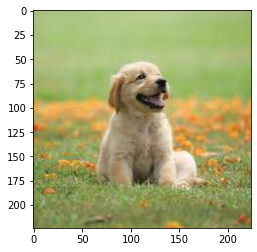

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10867841.0


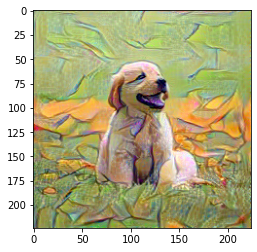

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6923655.5


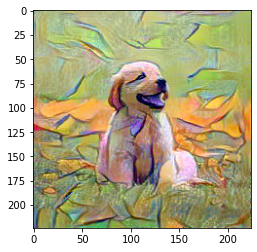

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5286770.0


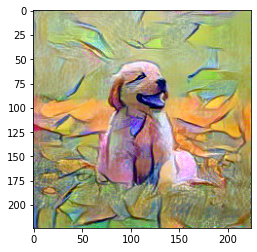

In [11]:
apply_style_transfer("dog.jpeg", "picasso.jpeg", 3000, 1000)

torch.Size([1, 3, 224, 224])
167203376.0


<ipython-input-9-1bc154ee3753>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(image_processor(content_target).unsqueeze(0), requires_grad=True, device=device)


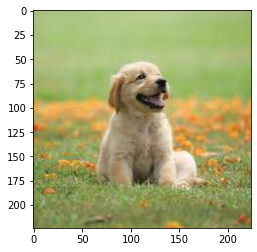

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1127352.75


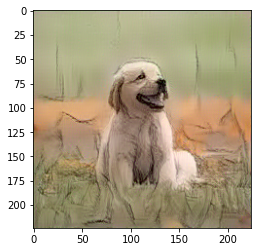

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


547297.4375


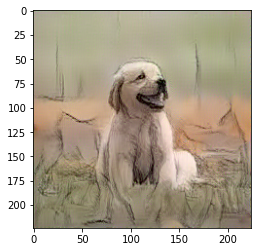

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


355602.375


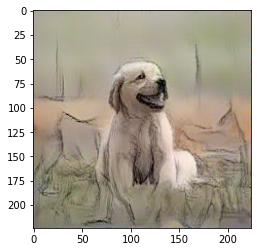

In [12]:
apply_style_transfer("dog.jpeg", "dog9.jpeg", 3000, 1000)

torch.Size([1, 3, 224, 224])
177717456.0


<ipython-input-9-1bc154ee3753>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(image_processor(content_target).unsqueeze(0), requires_grad=True, device=device)


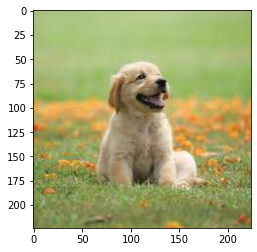

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2029207.0


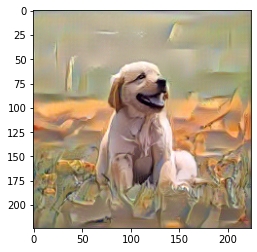

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1126835.875


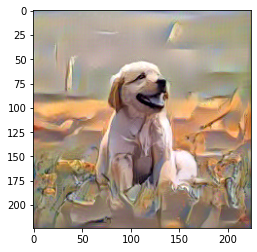

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


820758.5


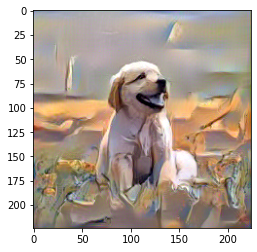

In [13]:
apply_style_transfer("dog.jpeg", "time2.jpeg", 3000, 1000)

torch.Size([1, 3, 224, 224])
206714176.0


<ipython-input-9-1bc154ee3753>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(image_processor(content_target).unsqueeze(0), requires_grad=True, device=device)


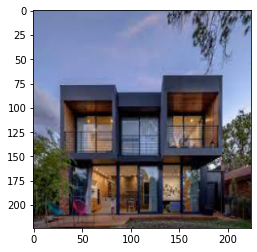

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1978128.25


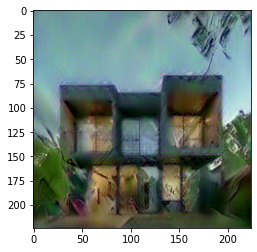

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1018244.5625


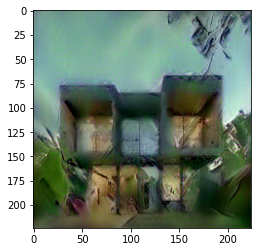

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


739782.125


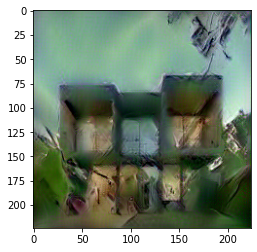

In [14]:
apply_style_transfer("house.jpeg", "time.jpeg", 3000, 1000)

torch.Size([1, 3, 224, 224])
108355312.0


<ipython-input-9-1bc154ee3753>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(image_processor(content_target).unsqueeze(0), requires_grad=True, device=device)


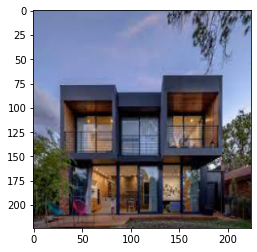

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1615051.625


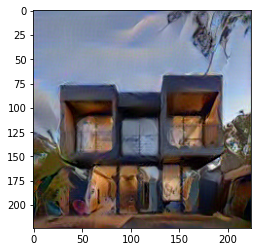

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


981264.8125


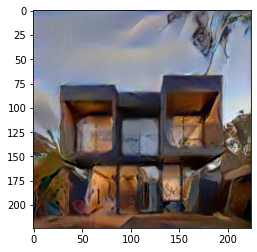

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


756965.75


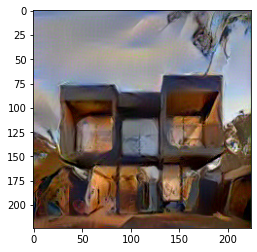

In [16]:
apply_style_transfer("house.jpeg", "time2.jpeg", 3000, 1000)

torch.Size([1, 3, 224, 224])
491645600.0


<ipython-input-9-1bc154ee3753>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(image_processor(content_target).unsqueeze(0), requires_grad=True, device=device)


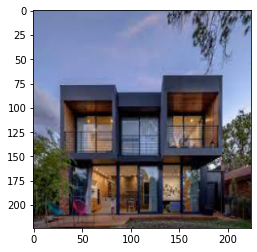

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14968433.0


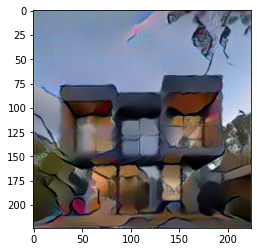

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9420814.0


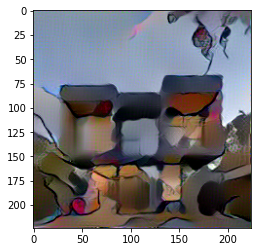

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7062959.0


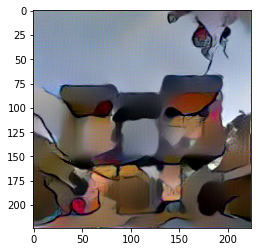

In [17]:
apply_style_transfer("house.jpeg", "mouse.jpeg", 3000, 1000)